# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11461
EM converged at iteration 32, llf=-11222, convergence criterion=9.7823e-07 < tolerance=1e-06
EM start iterations, llf=-11474
EM converged at iteration 32, llf=-11234, convergence criterion=9.781e-07 < tolerance=1e-06
EM start iterations, llf=-11526
EM converged at iteration 32, llf=-11283, convergence criterion=9.8344e-07 < tolerance=1e-06
EM start iterations, llf=-11532
EM converged at iteration 32, llf=-11290, convergence criterion=9.8544e-07 < tolerance=1e-06
EM start iterations, llf=-11596
EM converged at iteration 32, llf=-11348, convergence criterion=9.493e-07 < tolerance=1e-06
EM start iterations, llf=-11604
EM converged at iteration 32, llf=-11355, convergence criterion=9.3635e-07 < tolerance=1e-06
EM start iterations, llf=-11657
EM converged at iteration 32, llf=-11409, convergence criterion=9.7651e-07 < tolerance=1e-06
EM start iterations, llf=-11657
EM converged at iteration 32, llf=-11409, convergence criterion=9.7651e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13063
EM converged at iteration 26, llf=-12876, convergence criterion=9.7073e-07 < tolerance=1e-06
EM start iterations, llf=-13125
EM converged at iteration 25, llf=-12948, convergence criterion=9.6378e-07 < tolerance=1e-06
EM start iterations, llf=-13131
EM converged at iteration 27, llf=-12952, convergence criterion=9.9931e-07 < tolerance=1e-06
EM start iterations, llf=-13183
EM converged at iteration 28, llf=-12998, convergence criterion=9.7529e-07 < tolerance=1e-06
EM start iterations, llf=-13183
EM converged at iteration 28, llf=-12998, convergence criterion=9.7529e-07 < tolerance=1e-06
EM start iterations, llf=-13194
EM converged at iteration 30, llf=-13011, convergence criterion=8.7252e-07 < tolerance=1e-06
EM start iterations, llf=-13246
EM converged at iteration 29, llf=-13065, convergence criterion=9.7147e-07 < tolerance=1e-06
EM start iterations, llf=-13251
EM converged at iteration 30, llf=-13069, convergence criterion=9.1598e-07 < tolerance=1e-06


EM start iterations, llf=-14759
EM converged at iteration 30, llf=-14563, convergence criterion=9.9386e-07 < tolerance=1e-06
EM start iterations, llf=-14759
EM converged at iteration 30, llf=-14563, convergence criterion=9.9386e-07 < tolerance=1e-06
EM start iterations, llf=-14768
EM converged at iteration 30, llf=-14573, convergence criterion=9.9276e-07 < tolerance=1e-06
EM start iterations, llf=-14819
EM converged at iteration 30, llf=-14623, convergence criterion=9.7199e-07 < tolerance=1e-06
EM start iterations, llf=-14830
EM converged at iteration 30, llf=-14634, convergence criterion=9.5709e-07 < tolerance=1e-06
EM start iterations, llf=-14880
EM converged at iteration 30, llf=-14684, convergence criterion=9.43e-07 < tolerance=1e-06
EM start iterations, llf=-14887
EM converged at iteration 30, llf=-14691, convergence criterion=9.1428e-07 < tolerance=1e-06
EM start iterations, llf=-14934
EM converged at iteration 30, llf=-14736, convergence criterion=8.8903e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16436
EM converged at iteration 29, llf=-16211, convergence criterion=8.6133e-07 < tolerance=1e-06
EM start iterations, llf=-16441
EM converged at iteration 29, llf=-16216, convergence criterion=8.6319e-07 < tolerance=1e-06
EM start iterations, llf=-16493
EM converged at iteration 28, llf=-16268, convergence criterion=9.7479e-07 < tolerance=1e-06
EM start iterations, llf=-16500
EM converged at iteration 28, llf=-16274, convergence criterion=9.8547e-07 < tolerance=1e-06
EM start iterations, llf=-16555
EM converged at iteration 28, llf=-16329, convergence criterion=9.7665e-07 < tolerance=1e-06
EM start iterations, llf=-16555
EM converged at iteration 28, llf=-16329, convergence criterion=9.7665e-07 < tolerance=1e-06
EM start iterations, llf=-16564
EM converged at iteration 28, llf=-16339, convergence criterion=9.5689e-07 < tolerance=1e-06
EM start iterations, llf=-16614
EM converged at iteration 28, llf=-16389, convergence criterion=9.0578e-07 < tolerance=1e-06


EM start iterations, llf=-17912
EM converged at iteration 25, llf=-17680, convergence criterion=8.6523e-07 < tolerance=1e-06
EM start iterations, llf=-17968
EM converged at iteration 25, llf=-17735, convergence criterion=8.6607e-07 < tolerance=1e-06
EM start iterations, llf=-17968
EM converged at iteration 25, llf=-17735, convergence criterion=8.6607e-07 < tolerance=1e-06
EM start iterations, llf=-17974
EM converged at iteration 25, llf=-17741, convergence criterion=8.6677e-07 < tolerance=1e-06
EM start iterations, llf=-18024
EM converged at iteration 25, llf=-17790, convergence criterion=9.0193e-07 < tolerance=1e-06
EM start iterations, llf=-18030
EM converged at iteration 25, llf=-17797, convergence criterion=9.0268e-07 < tolerance=1e-06
EM start iterations, llf=-18085
EM converged at iteration 25, llf=-17850, convergence criterion=8.9701e-07 < tolerance=1e-06
EM start iterations, llf=-18093
EM converged at iteration 25, llf=-17858, convergence criterion=9.0283e-07 < tolerance=1e-06


EM start iterations, llf=-12008
EM converged at iteration 41, llf=-11744, convergence criterion=9.8083e-07 < tolerance=1e-06
EM start iterations, llf=-11991
EM converged at iteration 41, llf=-11723, convergence criterion=9.4995e-07 < tolerance=1e-06
EM start iterations, llf=-12056
EM converged at iteration 41, llf=-11799, convergence criterion=9.6087e-07 < tolerance=1e-06
EM start iterations, llf=-12075
EM converged at iteration 41, llf=-11824, convergence criterion=9.6544e-07 < tolerance=1e-06
EM start iterations, llf=-12108
EM converged at iteration 44, llf=-11879, convergence criterion=9.5478e-07 < tolerance=1e-06
EM start iterations, llf=-12107
EM converged at iteration 43, llf=-11876, convergence criterion=9.8887e-07 < tolerance=1e-06
EM start iterations, llf=-12110
EM converged at iteration 41, llf=-11886, convergence criterion=9.5489e-07 < tolerance=1e-06
EM start iterations, llf=-12110
EM converged at iteration 41, llf=-11886, convergence criterion=9.5489e-07 < tolerance=1e-06


EM start iterations, llf=-13595
EM converged at iteration 41, llf=-13399, convergence criterion=9.9953e-07 < tolerance=1e-06
EM start iterations, llf=-13633
EM converged at iteration 40, llf=-13428, convergence criterion=9.8801e-07 < tolerance=1e-06
EM start iterations, llf=-13638
EM converged at iteration 42, llf=-13441, convergence criterion=9.5793e-07 < tolerance=1e-06
EM start iterations, llf=-13683
EM converged at iteration 45, llf=-13494, convergence criterion=9.6488e-07 < tolerance=1e-06
EM start iterations, llf=-13683
EM converged at iteration 45, llf=-13494, convergence criterion=9.6488e-07 < tolerance=1e-06
EM start iterations, llf=-13694
EM converged at iteration 45, llf=-13505, convergence criterion=9.6638e-07 < tolerance=1e-06
EM start iterations, llf=-13741
EM converged at iteration 44, llf=-13551, convergence criterion=9.8972e-07 < tolerance=1e-06
EM start iterations, llf=-13749
EM converged at iteration 44, llf=-13557, convergence criterion=9.536e-07 < tolerance=1e-06
E

EM start iterations, llf=-15309
EM converged at iteration 38, llf=-15097, convergence criterion=9.7767e-07 < tolerance=1e-06
EM start iterations, llf=-15309
EM converged at iteration 38, llf=-15097, convergence criterion=9.7767e-07 < tolerance=1e-06
EM start iterations, llf=-15318
EM converged at iteration 38, llf=-15105, convergence criterion=9.5115e-07 < tolerance=1e-06
EM start iterations, llf=-15370
EM converged at iteration 38, llf=-15156, convergence criterion=9.5193e-07 < tolerance=1e-06
EM start iterations, llf=-15373
EM converged at iteration 38, llf=-15158, convergence criterion=9.6534e-07 < tolerance=1e-06
EM start iterations, llf=-15426
EM converged at iteration 39, llf=-15210, convergence criterion=9.4369e-07 < tolerance=1e-06
EM start iterations, llf=-15431
EM converged at iteration 38, llf=-15214, convergence criterion=9.9639e-07 < tolerance=1e-06
EM start iterations, llf=-15474
EM converged at iteration 39, llf=-15258, convergence criterion=9.4928e-07 < tolerance=1e-06


EM start iterations, llf=-16974
EM converged at iteration 34, llf=-16755, convergence criterion=9.7902e-07 < tolerance=1e-06
EM start iterations, llf=-16980
EM converged at iteration 34, llf=-16760, convergence criterion=9.7788e-07 < tolerance=1e-06
EM start iterations, llf=-17026
EM converged at iteration 34, llf=-16806, convergence criterion=9.6424e-07 < tolerance=1e-06
EM start iterations, llf=-17034
EM converged at iteration 34, llf=-16813, convergence criterion=9.6109e-07 < tolerance=1e-06
EM start iterations, llf=-17085
EM converged at iteration 34, llf=-16862, convergence criterion=9.554e-07 < tolerance=1e-06
EM start iterations, llf=-17085
EM converged at iteration 34, llf=-16862, convergence criterion=9.554e-07 < tolerance=1e-06
EM start iterations, llf=-17104
EM converged at iteration 34, llf=-16881, convergence criterion=9.6361e-07 < tolerance=1e-06
EM start iterations, llf=-17155
EM converged at iteration 33, llf=-16933, convergence criterion=9.6565e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18448
EM converged at iteration 33, llf=-18201, convergence criterion=9.8013e-07 < tolerance=1e-06
EM start iterations, llf=-18497
EM converged at iteration 33, llf=-18250, convergence criterion=9.5306e-07 < tolerance=1e-06
EM start iterations, llf=-18497
EM converged at iteration 33, llf=-18250, convergence criterion=9.5306e-07 < tolerance=1e-06
EM start iterations, llf=-18505
EM converged at iteration 33, llf=-18259, convergence criterion=9.5071e-07 < tolerance=1e-06
EM start iterations, llf=-18560
EM converged at iteration 33, llf=-18315, convergence criterion=9.4857e-07 < tolerance=1e-06
EM start iterations, llf=-18568
EM converged at iteration 33, llf=-18322, convergence criterion=9.4706e-07 < tolerance=1e-06
EM start iterations, llf=-18619
EM converged at iteration 33, llf=-18372, convergence criterion=9.4857e-07 < tolerance=1e-06
EM start iterations, llf=-18628
EM converged at iteration 33, llf=-18380, convergence criterion=9.4775e-07 < tolerance=1e-06


EM start iterations, llf=-12411
EM converged at iteration 41, llf=-12198, convergence criterion=9.9573e-07 < tolerance=1e-06
EM start iterations, llf=-12416
EM converged at iteration 41, llf=-12205, convergence criterion=9.9541e-07 < tolerance=1e-06
EM start iterations, llf=-12457
EM converged at iteration 41, llf=-12243, convergence criterion=9.6857e-07 < tolerance=1e-06
EM start iterations, llf=-12464
EM converged at iteration 41, llf=-12251, convergence criterion=9.7057e-07 < tolerance=1e-06
EM start iterations, llf=-12503
EM converged at iteration 41, llf=-12286, convergence criterion=9.3937e-07 < tolerance=1e-06
EM start iterations, llf=-12514
EM converged at iteration 40, llf=-12296, convergence criterion=9.8912e-07 < tolerance=1e-06
EM start iterations, llf=-12569
EM converged at iteration 42, llf=-12359, convergence criterion=9.738e-07 < tolerance=1e-06
EM start iterations, llf=-12569
EM converged at iteration 42, llf=-12359, convergence criterion=9.738e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14106
EM converged at iteration 45, llf=-13910, convergence criterion=9.4662e-07 < tolerance=1e-06
EM start iterations, llf=-14159
EM converged at iteration 46, llf=-13968, convergence criterion=9.5927e-07 < tolerance=1e-06
EM start iterations, llf=-14168
EM converged at iteration 45, llf=-13973, convergence criterion=9.8223e-07 < tolerance=1e-06
EM start iterations, llf=-14218
EM converged at iteration 46, llf=-14026, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-14218
EM converged at iteration 46, llf=-14026, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-14226
EM converged at iteration 46, llf=-14032, convergence criterion=9.4854e-07 < tolerance=1e-06
EM start iterations, llf=-14282
EM converged at iteration 45, llf=-14087, convergence criterion=9.9227e-07 < tolerance=1e-06
EM start iterations, llf=-14290
EM converged at iteration 44, llf=-14094, convergence criterion=9.9716e-07 < tolerance=1e-06


EM start iterations, llf=-15841
EM converged at iteration 43, llf=-15625, convergence criterion=9.5469e-07 < tolerance=1e-06
EM start iterations, llf=-15841
EM converged at iteration 43, llf=-15625, convergence criterion=9.5469e-07 < tolerance=1e-06
EM start iterations, llf=-15850
EM converged at iteration 43, llf=-15633, convergence criterion=9.5571e-07 < tolerance=1e-06
EM start iterations, llf=-15899
EM converged at iteration 43, llf=-15682, convergence criterion=9.4288e-07 < tolerance=1e-06
EM start iterations, llf=-15908
EM converged at iteration 43, llf=-15691, convergence criterion=9.3942e-07 < tolerance=1e-06
EM start iterations, llf=-15955
EM converged at iteration 42, llf=-15738, convergence criterion=9.8748e-07 < tolerance=1e-06
EM start iterations, llf=-15963
EM converged at iteration 42, llf=-15745, convergence criterion=9.8372e-07 < tolerance=1e-06
EM start iterations, llf=-16014
EM converged at iteration 42, llf=-15795, convergence criterion=9.7879e-07 < tolerance=1e-06


EM start iterations, llf=-17495
EM converged at iteration 38, llf=-17268, convergence criterion=9.4715e-07 < tolerance=1e-06
EM start iterations, llf=-17501
EM converged at iteration 38, llf=-17275, convergence criterion=9.4304e-07 < tolerance=1e-06
EM start iterations, llf=-17554
EM converged at iteration 38, llf=-17327, convergence criterion=9.4104e-07 < tolerance=1e-06
EM start iterations, llf=-17561
EM converged at iteration 38, llf=-17334, convergence criterion=9.4204e-07 < tolerance=1e-06
EM start iterations, llf=-17616
EM converged at iteration 38, llf=-17389, convergence criterion=9.5228e-07 < tolerance=1e-06
EM start iterations, llf=-17616
EM converged at iteration 38, llf=-17389, convergence criterion=9.5228e-07 < tolerance=1e-06
EM start iterations, llf=-17620
EM converged at iteration 38, llf=-17391, convergence criterion=9.5341e-07 < tolerance=1e-06
EM start iterations, llf=-17670
EM converged at iteration 38, llf=-17440, convergence criterion=9.419e-07 < tolerance=1e-06
E

EM start iterations, llf=-18697
EM converged at iteration 38, llf=-18446, convergence criterion=9.5886e-07 < tolerance=1e-06
EM start iterations, llf=-18754
EM converged at iteration 38, llf=-18503, convergence criterion=9.5237e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:30:03.845109.
EM start iterations, llf=-10983
EM converged at iteration 25, llf=-10841, convergence criterion=9.7295e-07 < tolerance=1e-06
EM start iterations, llf=-10996
EM converged at iteration 25, llf=-10853, convergence criterion=9.767e-07 < tolerance=1e-06
EM start iterations, llf=-11046
EM converged at iteration 25, llf=-10904, convergence criterion=9.4068e-07 < tolerance=1e-06
EM start iterations, llf=-11054
EM converged at iteration 25, llf=-10912, convergence criterion=9.4663e-07 < tolerance=1e-06
EM start iterations, llf=-11111
EM converged at iteration 22, llf=-10969, convergence criterion=9.492e-07 < tolerance=1e-06
EM start iterations, llf=-11121
EM converged at i

EM start iterations, llf=-12348
EM converged at iteration 24, llf=-12204, convergence criterion=9.3529e-07 < tolerance=1e-06
EM start iterations, llf=-12361
EM converged at iteration 24, llf=-12216, convergence criterion=9.446e-07 < tolerance=1e-06
EM start iterations, llf=-12393
EM converged at iteration 24, llf=-12248, convergence criterion=9.4267e-07 < tolerance=1e-06
EM start iterations, llf=-12400
EM converged at iteration 24, llf=-12252, convergence criterion=9.6221e-07 < tolerance=1e-06
EM start iterations, llf=-12459
EM converged at iteration 24, llf=-12306, convergence criterion=9.4933e-07 < tolerance=1e-06
EM start iterations, llf=-12464
EM converged at iteration 23, llf=-12313, convergence criterion=9.9881e-07 < tolerance=1e-06
EM start iterations, llf=-12505
EM converged at iteration 23, llf=-12354, convergence criterion=9.4687e-07 < tolerance=1e-06
EM start iterations, llf=-12505
EM converged at iteration 23, llf=-12354, convergence criterion=9.4687e-07 < tolerance=1e-06
E

EM start iterations, llf=-13919
EM converged at iteration 20, llf=-13764, convergence criterion=9.4681e-07 < tolerance=1e-06
EM start iterations, llf=-13969
EM converged at iteration 20, llf=-13815, convergence criterion=9.4901e-07 < tolerance=1e-06
EM start iterations, llf=-13977
EM converged at iteration 20, llf=-13822, convergence criterion=9.4643e-07 < tolerance=1e-06
EM start iterations, llf=-14027
EM converged at iteration 20, llf=-13872, convergence criterion=9.2754e-07 < tolerance=1e-06
EM start iterations, llf=-14027
EM converged at iteration 20, llf=-13872, convergence criterion=9.2754e-07 < tolerance=1e-06
EM start iterations, llf=-14034
EM converged at iteration 20, llf=-13880, convergence criterion=9.3318e-07 < tolerance=1e-06
EM start iterations, llf=-14083
EM converged at iteration 20, llf=-13928, convergence criterion=9.1641e-07 < tolerance=1e-06
EM start iterations, llf=-14090
EM converged at iteration 19, llf=-13935, convergence criterion=9.9564e-07 < tolerance=1e-06


EM start iterations, llf=-15580
EM converged at iteration 20, llf=-15419, convergence criterion=9.5915e-07 < tolerance=1e-06
EM start iterations, llf=-15580
EM converged at iteration 20, llf=-15419, convergence criterion=9.5915e-07 < tolerance=1e-06
EM start iterations, llf=-15593
EM converged at iteration 20, llf=-15432, convergence criterion=9.5505e-07 < tolerance=1e-06
EM start iterations, llf=-15647
EM converged at iteration 20, llf=-15488, convergence criterion=9.8524e-07 < tolerance=1e-06
EM start iterations, llf=-15650
EM converged at iteration 21, llf=-15491, convergence criterion=9.1536e-07 < tolerance=1e-06
EM start iterations, llf=-15701
EM converged at iteration 20, llf=-15542, convergence criterion=9.923e-07 < tolerance=1e-06
EM start iterations, llf=-15708
EM converged at iteration 20, llf=-15548, convergence criterion=9.9581e-07 < tolerance=1e-06
EM start iterations, llf=-15759
EM converged at iteration 21, llf=-15600, convergence criterion=9.2848e-07 < tolerance=1e-06
E

EM start iterations, llf=-16984
EM converged at iteration 20, llf=-16826, convergence criterion=9.6161e-07 < tolerance=1e-06
EM start iterations, llf=-16998
EM converged at iteration 20, llf=-16840, convergence criterion=9.5323e-07 < tolerance=1e-06
EM start iterations, llf=-17052
EM converged at iteration 20, llf=-16892, convergence criterion=9.3976e-07 < tolerance=1e-06
EM start iterations, llf=-17058
EM converged at iteration 20, llf=-16898, convergence criterion=9.4004e-07 < tolerance=1e-06
EM start iterations, llf=-17111
EM converged at iteration 20, llf=-16951, convergence criterion=9.1043e-07 < tolerance=1e-06
EM start iterations, llf=-17111
EM converged at iteration 20, llf=-16951, convergence criterion=9.1043e-07 < tolerance=1e-06
EM start iterations, llf=-17116
EM converged at iteration 20, llf=-16956, convergence criterion=9.2017e-07 < tolerance=1e-06
EM start iterations, llf=-17162
EM converged at iteration 20, llf=-17003, convergence criterion=9.0653e-07 < tolerance=1e-06


EM start iterations, llf=-11423
EM converged at iteration 49, llf=-11277, convergence criterion=9.8552e-07 < tolerance=1e-06
EM start iterations, llf=-11426
EM converged at iteration 49, llf=-11279, convergence criterion=9.8694e-07 < tolerance=1e-06
EM start iterations, llf=-11494
EM converged at iteration 43, llf=-11347, convergence criterion=9.9133e-07 < tolerance=1e-06
EM start iterations, llf=-11494
EM converged at iteration 43, llf=-11347, convergence criterion=9.9133e-07 < tolerance=1e-06
EM start iterations, llf=-11506
EM converged at iteration 43, llf=-11361, convergence criterion=9.8765e-07 < tolerance=1e-06
EM start iterations, llf=-11584
EM converged at iteration 39, llf=-11442, convergence criterion=9.9123e-07 < tolerance=1e-06
EM start iterations, llf=-11570
EM converged at iteration 42, llf=-11428, convergence criterion=9.8512e-07 < tolerance=1e-06
EM start iterations, llf=-11559
EM converged at iteration 39, llf=-11409, convergence criterion=9.6803e-07 < tolerance=1e-06


EM start iterations, llf=-12838
EM converged at iteration 34, llf=-12680, convergence criterion=9.966e-07 < tolerance=1e-06
EM start iterations, llf=-12846
EM converged at iteration 34, llf=-12691, convergence criterion=9.8705e-07 < tolerance=1e-06
EM start iterations, llf=-12889
EM converged at iteration 35, llf=-12733, convergence criterion=9.6765e-07 < tolerance=1e-06
EM start iterations, llf=-12898
EM converged at iteration 35, llf=-12742, convergence criterion=9.9474e-07 < tolerance=1e-06
EM start iterations, llf=-12942
EM converged at iteration 35, llf=-12785, convergence criterion=9.9075e-07 < tolerance=1e-06
EM start iterations, llf=-12934
EM converged at iteration 34, llf=-12782, convergence criterion=9.8482e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 34, llf=-12821, convergence criterion=9.7172e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 34, llf=-12821, convergence criterion=9.7172e-07 < tolerance=1e-06
E

EM start iterations, llf=-14441
EM converged at iteration 27, llf=-14283, convergence criterion=9.7673e-07 < tolerance=1e-06
EM start iterations, llf=-14495
EM converged at iteration 27, llf=-14337, convergence criterion=9.8309e-07 < tolerance=1e-06
EM start iterations, llf=-14501
EM converged at iteration 27, llf=-14344, convergence criterion=9.8631e-07 < tolerance=1e-06
EM start iterations, llf=-14547
EM converged at iteration 27, llf=-14391, convergence criterion=9.5214e-07 < tolerance=1e-06
EM start iterations, llf=-14547
EM converged at iteration 27, llf=-14391, convergence criterion=9.5214e-07 < tolerance=1e-06
EM start iterations, llf=-14560
EM converged at iteration 27, llf=-14403, convergence criterion=9.389e-07 < tolerance=1e-06
EM start iterations, llf=-14615
EM converged at iteration 27, llf=-14456, convergence criterion=9.5288e-07 < tolerance=1e-06
EM start iterations, llf=-14614
EM converged at iteration 27, llf=-14456, convergence criterion=9.6504e-07 < tolerance=1e-06
E

EM start iterations, llf=-16096
EM converged at iteration 27, llf=-15934, convergence criterion=9.3107e-07 < tolerance=1e-06
EM start iterations, llf=-16096
EM converged at iteration 27, llf=-15934, convergence criterion=9.3107e-07 < tolerance=1e-06
EM start iterations, llf=-16105
EM converged at iteration 26, llf=-15942, convergence criterion=9.983e-07 < tolerance=1e-06
EM start iterations, llf=-16144
EM converged at iteration 26, llf=-15981, convergence criterion=9.7768e-07 < tolerance=1e-06
EM start iterations, llf=-16148
EM converged at iteration 26, llf=-15986, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-16194
EM converged at iteration 26, llf=-16033, convergence criterion=9.5814e-07 < tolerance=1e-06
EM start iterations, llf=-16203
EM converged at iteration 26, llf=-16042, convergence criterion=9.6936e-07 < tolerance=1e-06
EM start iterations, llf=-16250
EM converged at iteration 26, llf=-16088, convergence criterion=9.7562e-07 < tolerance=1e-06
E

EM start iterations, llf=-17502
EM converged at iteration 26, llf=-17339, convergence criterion=9.7092e-07 < tolerance=1e-06
EM start iterations, llf=-17510
EM converged at iteration 26, llf=-17346, convergence criterion=9.6632e-07 < tolerance=1e-06
EM start iterations, llf=-17559
EM converged at iteration 26, llf=-17395, convergence criterion=9.5128e-07 < tolerance=1e-06
EM start iterations, llf=-17566
EM converged at iteration 26, llf=-17402, convergence criterion=9.4632e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 26, llf=-17446, convergence criterion=9.4421e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 26, llf=-17446, convergence criterion=9.4421e-07 < tolerance=1e-06
EM start iterations, llf=-17616
EM converged at iteration 26, llf=-17451, convergence criterion=9.4749e-07 < tolerance=1e-06
EM start iterations, llf=-17670
EM converged at iteration 26, llf=-17504, convergence criterion=9.424e-07 < tolerance=1e-06
E

EM start iterations, llf=-11749
EM converged at iteration 48, llf=-11600, convergence criterion=9.7506e-07 < tolerance=1e-06
EM start iterations, llf=-11766
EM converged at iteration 46, llf=-11611, convergence criterion=9.9117e-07 < tolerance=1e-06
EM start iterations, llf=-11825
EM converged at iteration 47, llf=-11670, convergence criterion=9.8058e-07 < tolerance=1e-06
EM start iterations, llf=-11825
EM converged at iteration 47, llf=-11670, convergence criterion=9.8058e-07 < tolerance=1e-06
EM start iterations, llf=-11826
EM converged at iteration 50, llf=-11674, convergence criterion=9.7749e-07 < tolerance=1e-06
EM start iterations, llf=-11857
EM converged at iteration 53, llf=-11708, convergence criterion=9.8078e-07 < tolerance=1e-06
EM start iterations, llf=-11868
EM converged at iteration 51, llf=-11717, convergence criterion=9.7933e-07 < tolerance=1e-06
EM start iterations, llf=-11907
EM converged at iteration 53, llf=-11760, convergence criterion=9.7955e-07 < tolerance=1e-06


EM start iterations, llf=-13314
EM converged at iteration 50, llf=-13156, convergence criterion=9.9084e-07 < tolerance=1e-06
EM start iterations, llf=-13320
EM converged at iteration 50, llf=-13162, convergence criterion=9.9083e-07 < tolerance=1e-06
EM start iterations, llf=-13383
EM converged at iteration 49, llf=-13225, convergence criterion=9.7008e-07 < tolerance=1e-06
EM start iterations, llf=-13389
EM converged at iteration 48, llf=-13231, convergence criterion=9.7941e-07 < tolerance=1e-06
EM start iterations, llf=-13438
EM converged at iteration 48, llf=-13281, convergence criterion=9.8434e-07 < tolerance=1e-06
EM start iterations, llf=-13447
EM converged at iteration 47, llf=-13290, convergence criterion=9.859e-07 < tolerance=1e-06
EM start iterations, llf=-13496
EM converged at iteration 46, llf=-13338, convergence criterion=9.6887e-07 < tolerance=1e-06
EM start iterations, llf=-13496
EM converged at iteration 46, llf=-13338, convergence criterion=9.6887e-07 < tolerance=1e-06
E

EM start iterations, llf=-14955
EM converged at iteration 42, llf=-14795, convergence criterion=9.8195e-07 < tolerance=1e-06
EM start iterations, llf=-15010
EM converged at iteration 42, llf=-14849, convergence criterion=9.7986e-07 < tolerance=1e-06
EM start iterations, llf=-15015
EM converged at iteration 42, llf=-14854, convergence criterion=9.8459e-07 < tolerance=1e-06
EM start iterations, llf=-15069
EM converged at iteration 43, llf=-14908, convergence criterion=9.7622e-07 < tolerance=1e-06
EM start iterations, llf=-15069
EM converged at iteration 43, llf=-14908, convergence criterion=9.7622e-07 < tolerance=1e-06
EM start iterations, llf=-15079
EM converged at iteration 43, llf=-14918, convergence criterion=9.6889e-07 < tolerance=1e-06
EM start iterations, llf=-15127
EM converged at iteration 42, llf=-14965, convergence criterion=9.981e-07 < tolerance=1e-06
EM start iterations, llf=-15135
EM converged at iteration 42, llf=-14974, convergence criterion=9.944e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16601
EM converged at iteration 46, llf=-16439, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-16601
EM converged at iteration 46, llf=-16439, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-16608
EM converged at iteration 46, llf=-16446, convergence criterion=9.9471e-07 < tolerance=1e-06
EM start iterations, llf=-16655
EM converged at iteration 45, llf=-16492, convergence criterion=9.9062e-07 < tolerance=1e-06
EM start iterations, llf=-16662
EM converged at iteration 45, llf=-16498, convergence criterion=9.8592e-07 < tolerance=1e-06
EM start iterations, llf=-16713
EM converged at iteration 46, llf=-16550, convergence criterion=9.7009e-07 < tolerance=1e-06
EM start iterations, llf=-16721
EM converged at iteration 46, llf=-16557, convergence criterion=9.7728e-07 < tolerance=1e-06
EM start iterations, llf=-16774
EM converged at iteration 45, llf=-16610, convergence criterion=9.961e-07 < tolerance=1e-06
E

EM start iterations, llf=-17726
EM converged at iteration 41, llf=-17566, convergence criterion=9.8495e-07 < tolerance=1e-06
EM start iterations, llf=-17737
EM converged at iteration 41, llf=-17577, convergence criterion=9.8066e-07 < tolerance=1e-06
EM start iterations, llf=-17791
EM converged at iteration 42, llf=-17631, convergence criterion=9.6726e-07 < tolerance=1e-06
EM start iterations, llf=-17795
EM converged at iteration 42, llf=-17635, convergence criterion=9.6728e-07 < tolerance=1e-06
EM start iterations, llf=-17850
EM converged at iteration 41, llf=-17690, convergence criterion=9.8906e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 1:56:06.461609.
Overall time taken for running all models: 8:07:19.085518.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


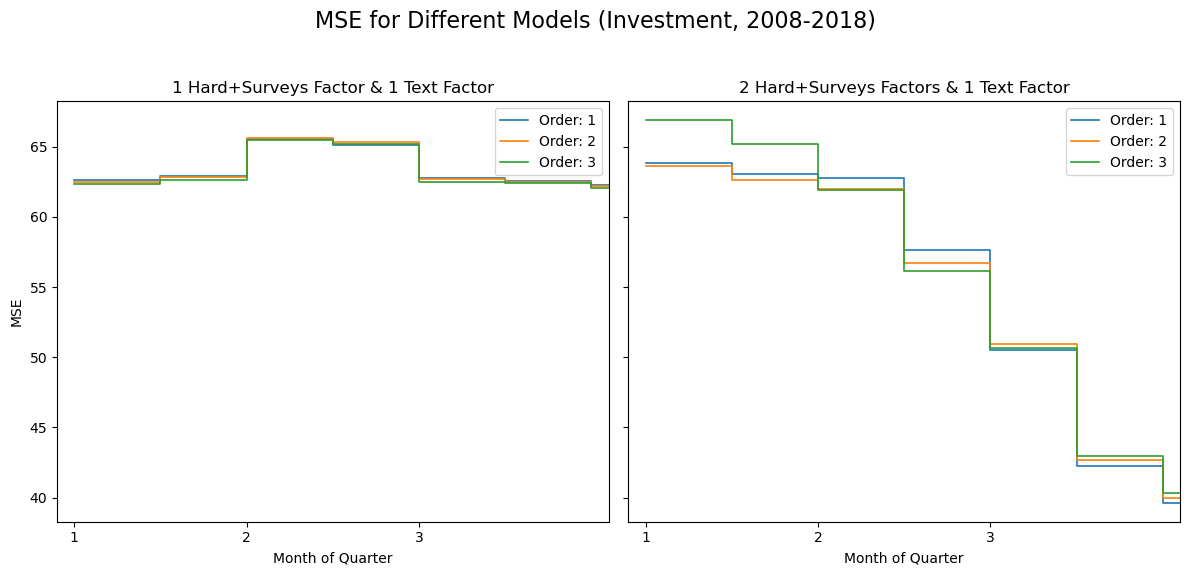

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


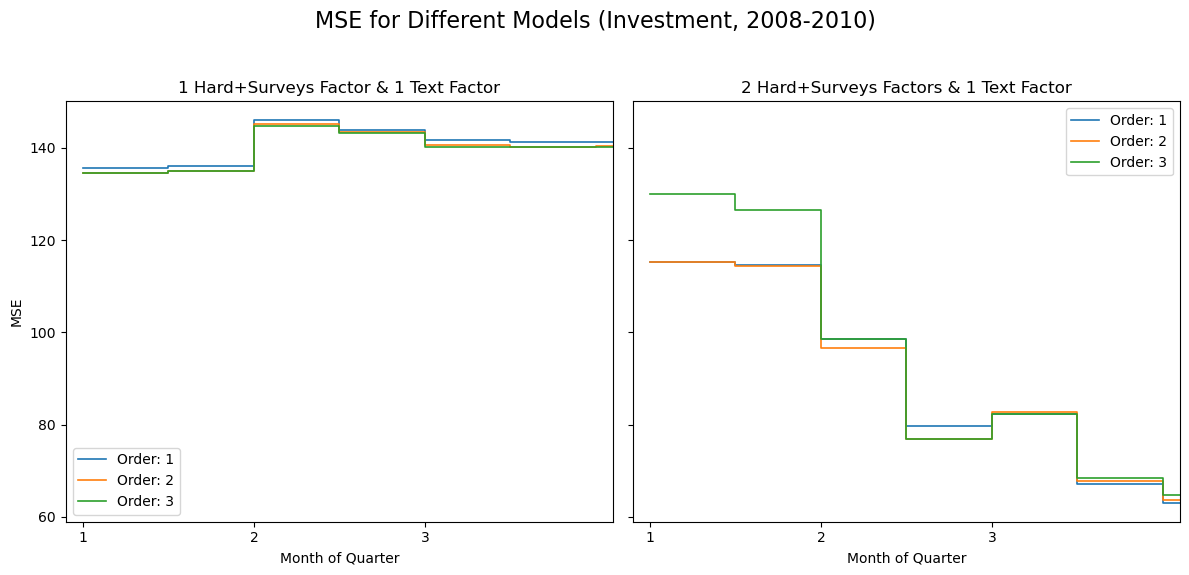

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


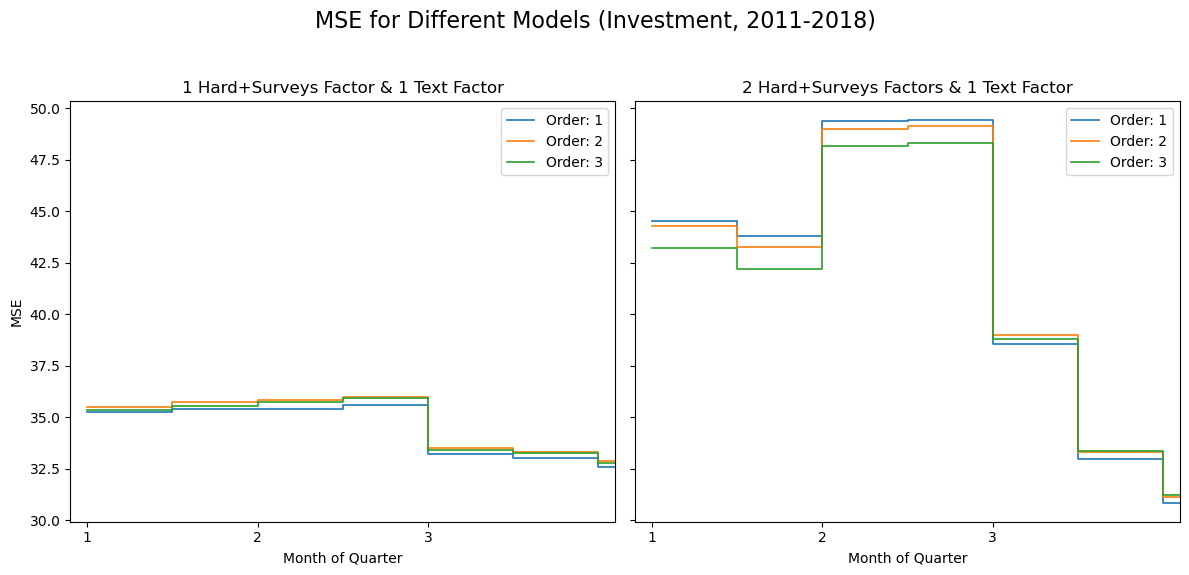

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


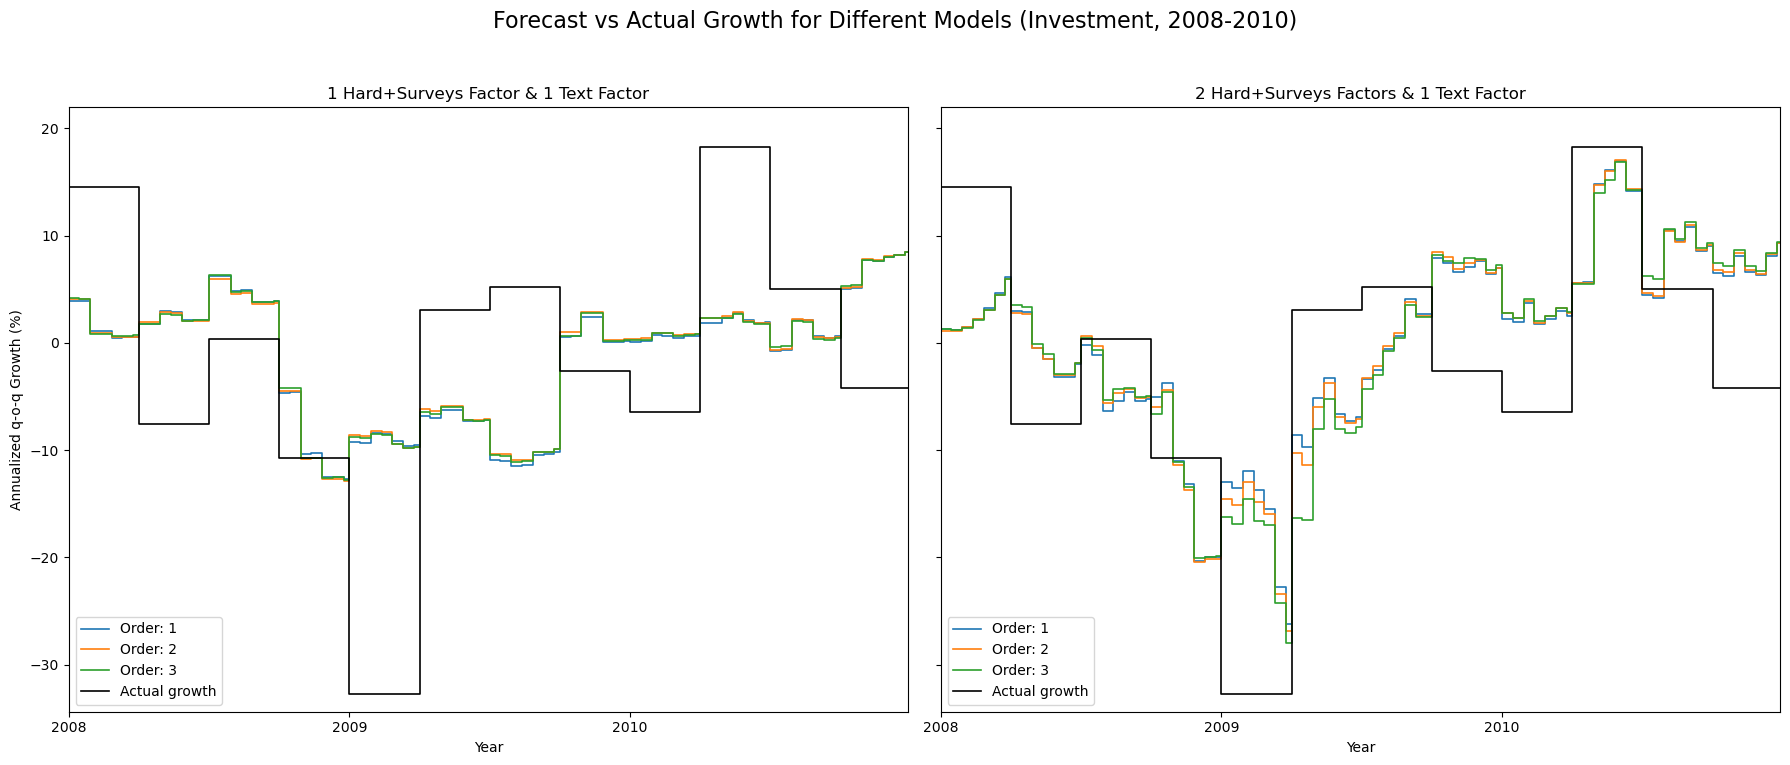

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


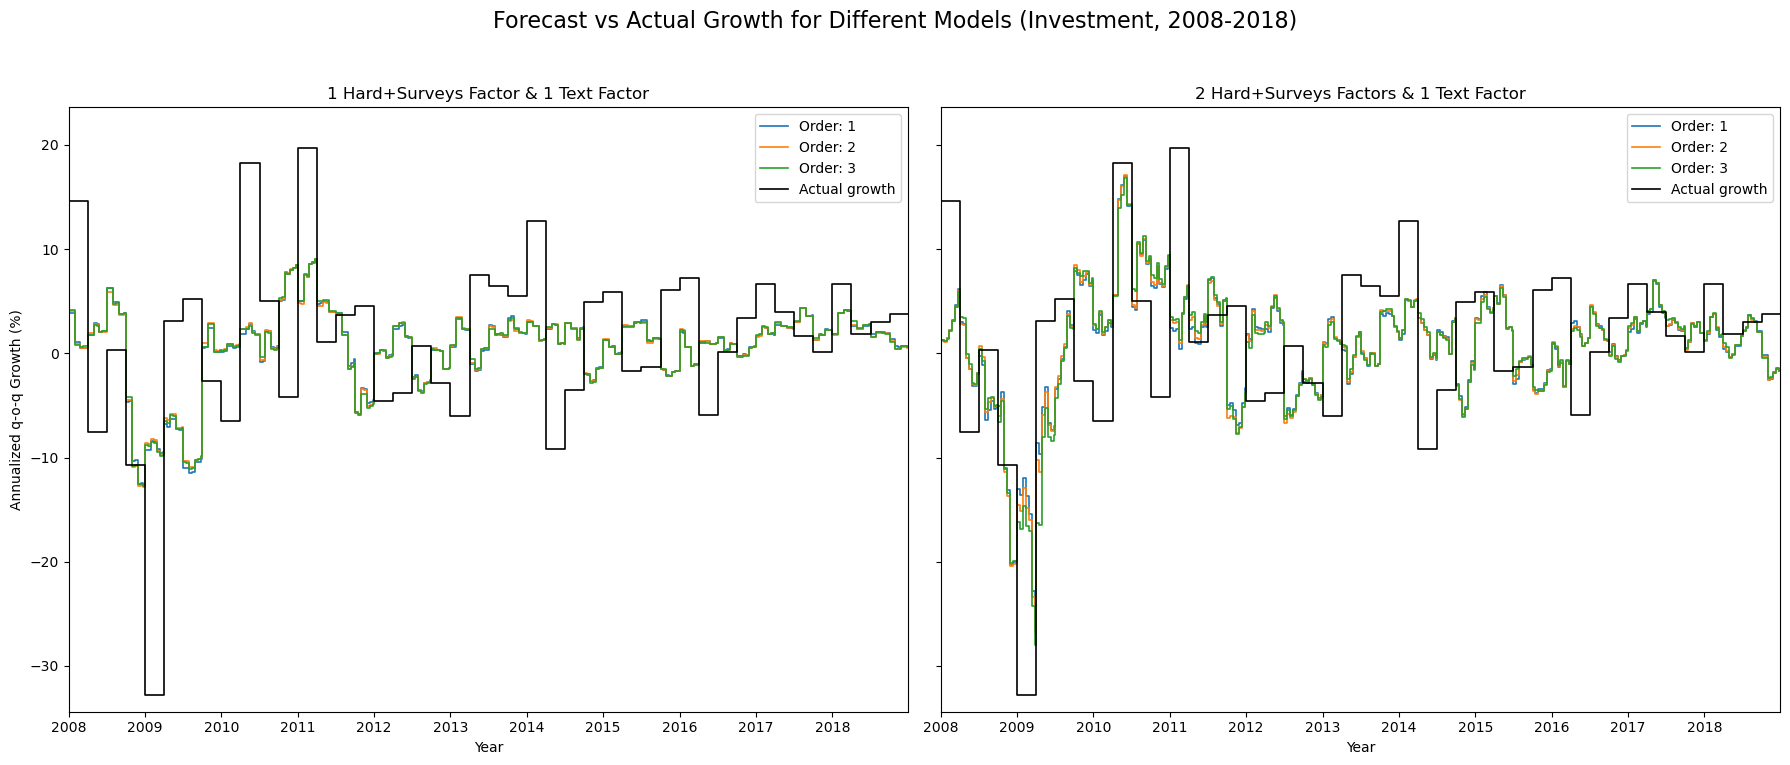

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


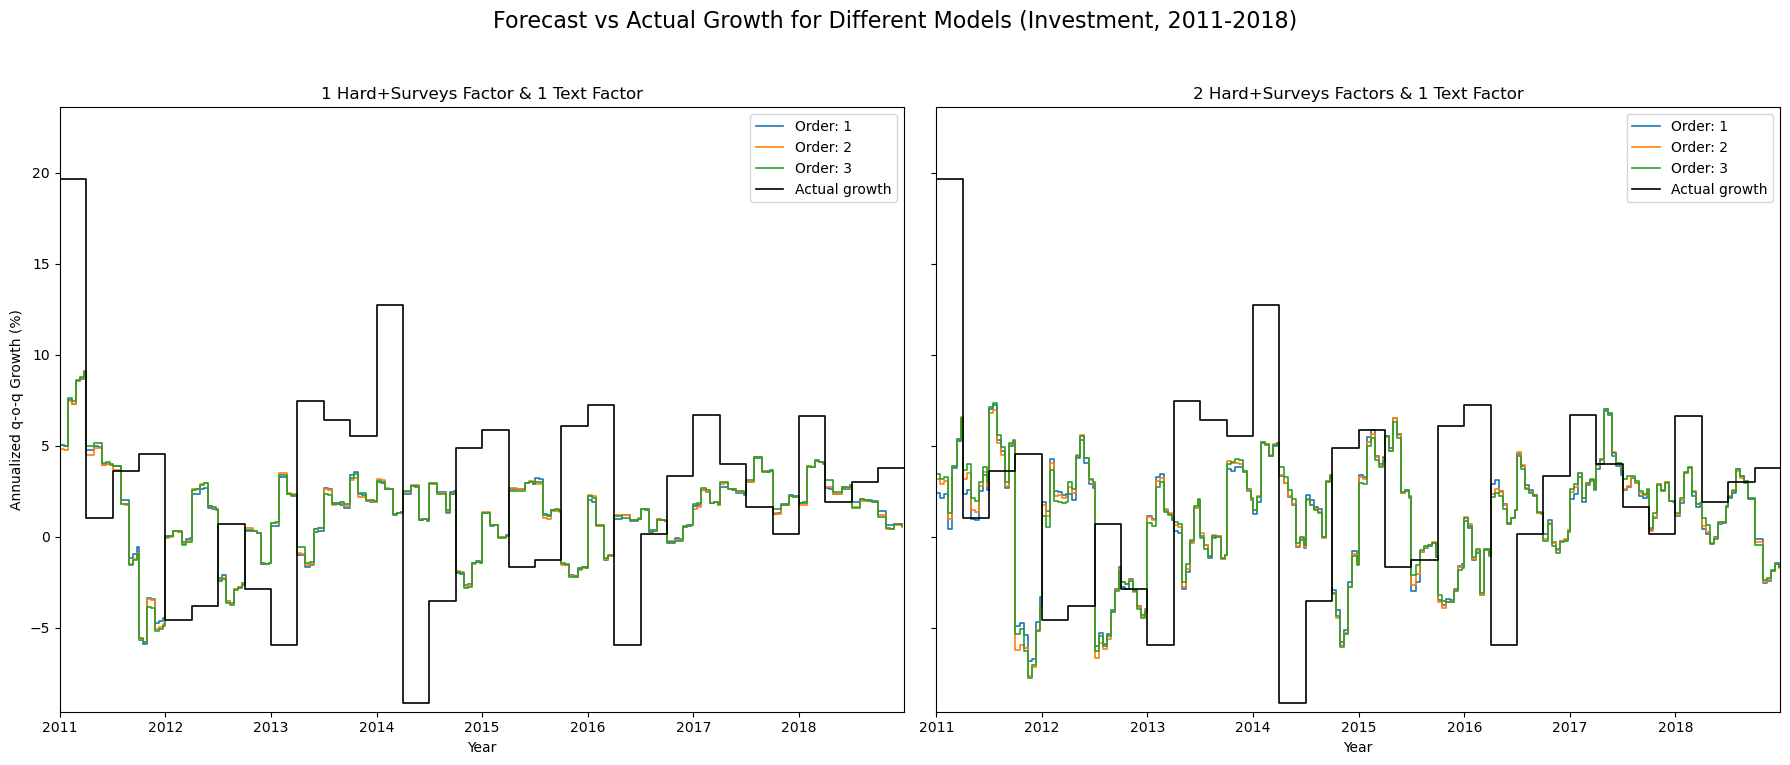

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()